In [2]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
all_file_path=glob('/kaggle/input/dataverse-files/dataverse_files/*edf')
print(len(all_file_path))

28


In [4]:
healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[5]]
patient_file_path = [i for i in all_file_path if 's' in i.split('/')[5]]
print(len(healthy_file_path)),print(len(patient_file_path))


14
14


(None, None)

In [5]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=25,overlap=0)
    epochs=epochs.get_data()
    return epochs #trials,channel,length

In [6]:
data=read_data(healthy_file_path[0])

Extracting EDF parameters from /kaggle/input/dataverse-files/dataverse_files/h09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 226249  =      0.000 ...   904.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
36 matching events found
No baseline correction applied
0 projection items acti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [7]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [8]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

14 14


In [10]:
epochs_array=control_epochs_array+patients_epochs_array
epochs_labels=control_epochs_labels+patients_epochs_labels
print(len(epochs_array),len(epochs_labels))

28 28


In [11]:
groups=[[i]*len(j) for i, j in enumerate(epochs_array)]
len(groups)

28

In [12]:
epochs_array = np.vstack(epochs_array)  # Assuming epochs_array contains arrays that can be stacked vertically
epochs_labels = np.hstack(epochs_labels)  # Convert to NumPy array
groups_array = np.hstack(groups)  # Convert to NumPy array

# Now you can safely check the shapes
#no. of segments,no. of channels,length of signal
print(epochs_array.shape, epochs_labels.shape, groups_array.shape)

(1142, 19, 6250) (1142,) (1142,)


In [13]:
print(epochs_array.shape,epochs_labels.shape,groups_array.shape)

(1142, 19, 6250) (1142,) (1142,)


In [14]:
import numpy as np
from tqdm import tqdm  # Use tqdm instead of tqdm_notebook
from scipy import stats  # Import stats from scipy

# Define feature functions
def mean(data):
    return np.mean(data, axis=-1)

def std(data):
    return np.std(data, axis=-1)

def ptp(data):
    return np.ptp(data, axis=-1)

def var(data):
    return np.var(data, axis=-1)

def minim(data):
    return np.min(data, axis=-1)

def maxim(data):
    return np.max(data, axis=-1)

def argminim(data):
    return np.argmin(data, axis=-1).astype(float)  # Convert to float for consistent shape

def argmaxim(data):
    return np.argmax(data, axis=-1).astype(float)  # Convert to float for consistent shape

def mean_square(data):
    return np.mean(data**2, axis=-1)

def rms(data):
    return np.sqrt(np.mean(data**2, axis=-1))

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data, axis=-1)), axis=-1)

def skewness(data):
    return stats.skew(data, axis=-1)  # Use stats.skew from scipy

def kurtosis(data):
    return stats.kurtosis(data, axis=-1)  # Use stats.kurtosis from scipy

# Concatenate features while ensuring each feature is calculated for each channel
def concatenate_features(data):
    # Stack each feature along the last axis for each channel
    return np.stack((
        mean(data),
        std(data),
        ptp(data),
        var(data),
        minim(data),
        maxim(data),
        argminim(data),
        argmaxim(data),
        mean_square(data),
        rms(data),
        abs_diffs_signal(data),
        skewness(data),
        kurtosis(data)
    ), axis=-1)  # Stack along the last axis to get 13 features per channel

# Process each epoch to create features array with shape (1142, 19, 13)
features = []
for data in tqdm(epochs_array):  # Replace tqdm_notebook with tqdm
    features.append(concatenate_features(data))

features = np.array(features)  # Expected shape: (1142, 19, 13)
print(features.shape)  # Should output (1142, 19, 13)


100%|██████████| 1142/1142 [00:09<00:00, 124.30it/s]

(1142, 19, 13)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

# Flatten the features from (1142, 19, 13) to (1142, 247) for the model
X = features.reshape(features.shape[0], -1)
y = epochs_labels  # Assuming epochs_labels is already defined with shape (1142,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
tree_model=rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.93


In [28]:
# Step 1: Check standard deviation of each feature in the training set
import numpy as np

stds = X_train.std(axis=0)

# Step 2: Identify high-variance feature indices
high_var_features = np.where(stds > 1e-4)[0]  # Adjust threshold if needed
print("High-variance feature indices:", high_var_features[:12])  # Print first 10 for preview


High-variance feature indices: [ 2  4  5  6  7 10 11 12 15 17 18 19]


In [29]:
# Define EEG channel and feature names
channels = [f"Ch{i}" for i in range(19)]
feature_types = [
    'mean', 'std', 'ptp', 'var', 'min', 'max', 'argmin', 'argmax',
    'mean_square', 'rms', 'abs_diff', 'skewness', 'kurtosis'
]

# Flattened feature names in same order as your flattened feature array
flat_feature_names = [f"{ch}_{feat}" for ch in channels for feat in feature_types]


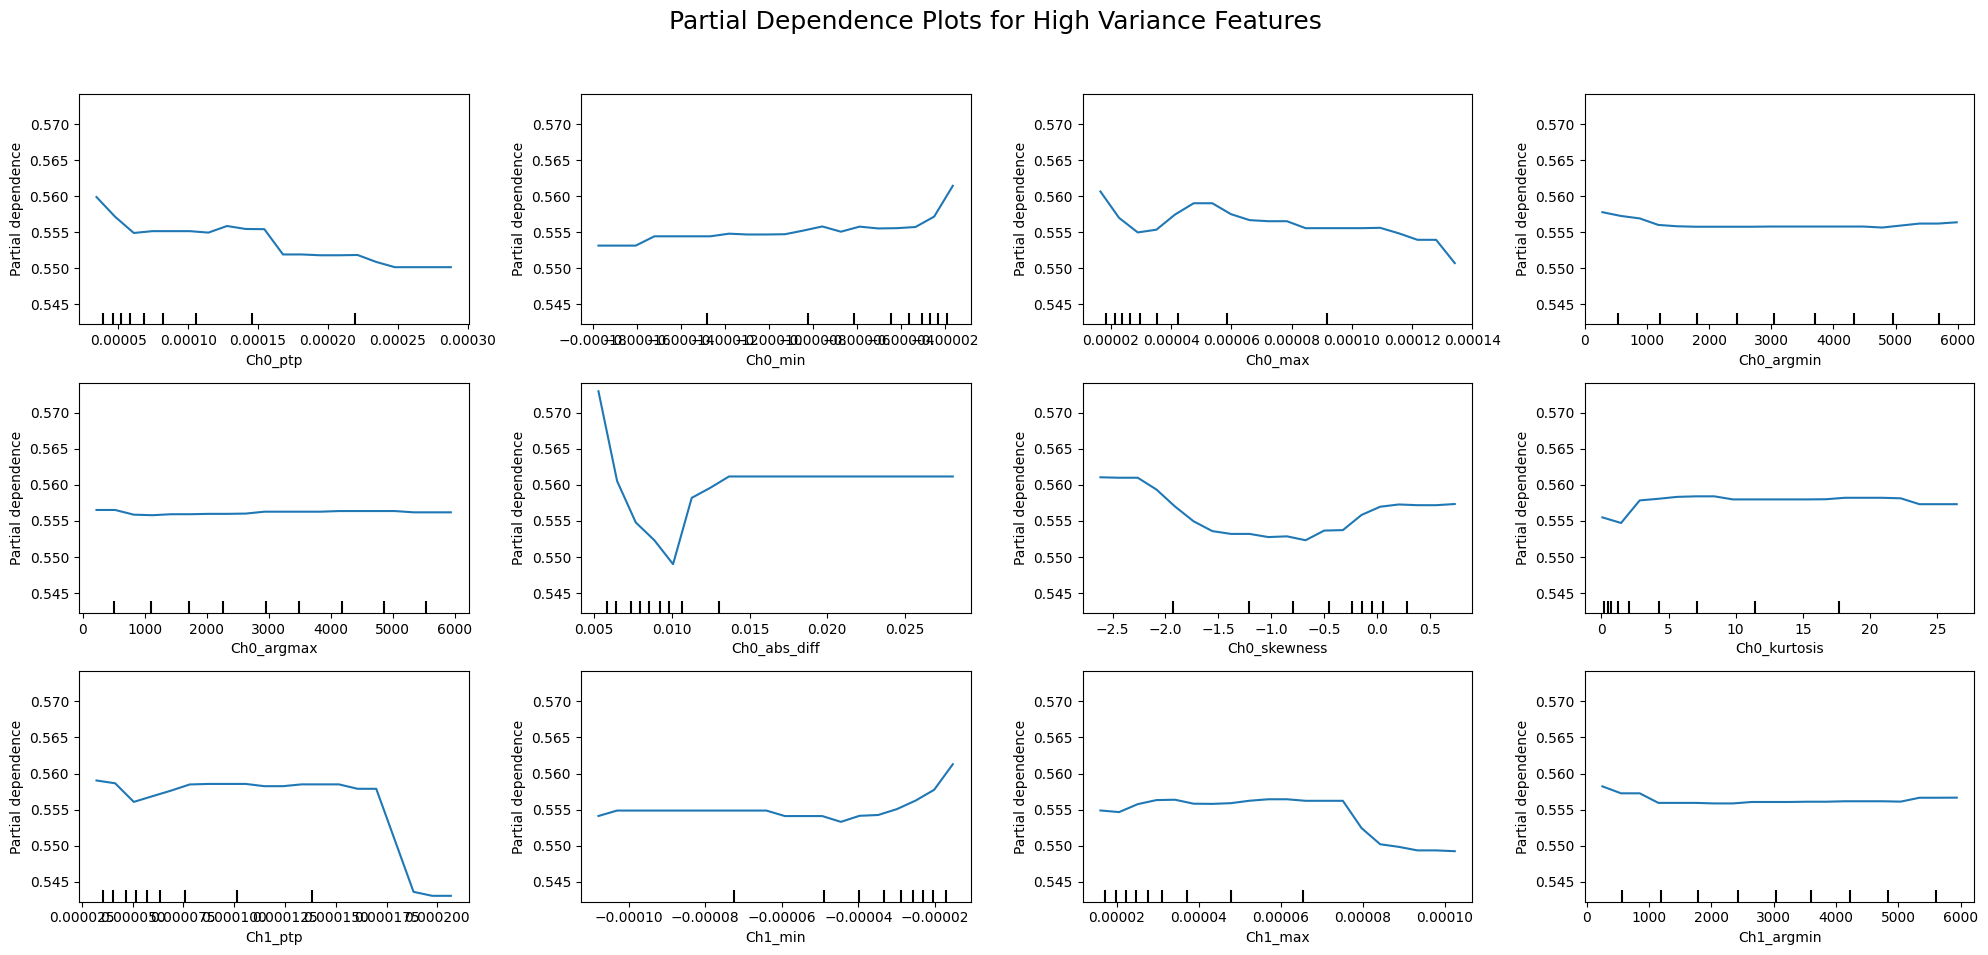

In [35]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with enough space for 12 plots (4 cols x 3 rows)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))  # Adjust rows/cols and size
ax = ax.flatten()  # Flatten the 2D array of axes for compatibility

# Generate the PDPs
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train,
    features=high_var_features[:12],
    feature_names=flat_feature_names,
    grid_resolution=20,
    ax=ax
)

plt.suptitle("Partial Dependence Plots for High Variance Features", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title
plt.show()


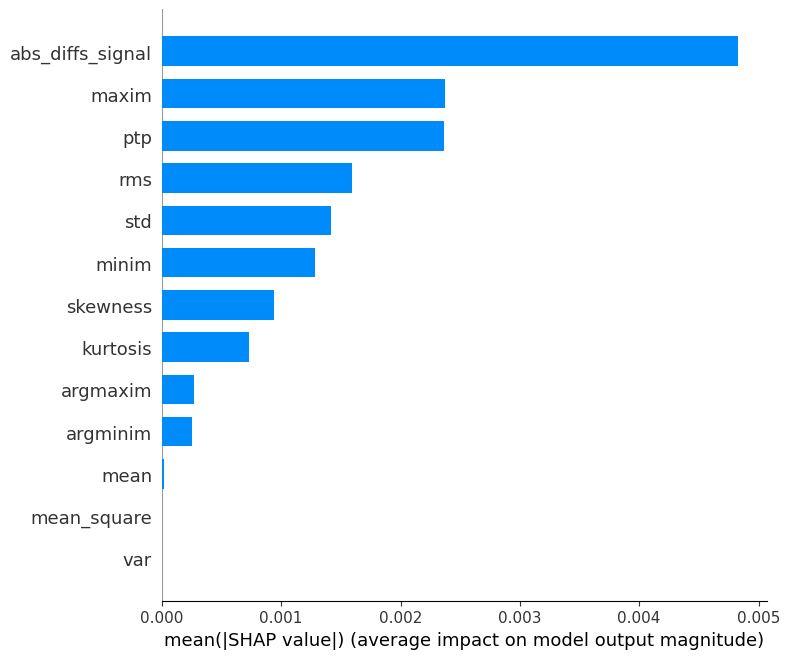

In [44]:
shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Reshape SHAP values back to (test_samples, 19, 13) for interpretability
shap_values_reshaped = shap_values[1].reshape(-1, 19, 13)

shap.summary_plot(shap_values_reshaped.mean(axis=1),  
                  feature_names=["mean", "std", "ptp", "var", "minim", "maxim", 
                                 "argminim", "argmaxim", "mean_square", "rms", 
                                 "abs_diffs_signal", "skewness", "kurtosis"],
                  plot_type="bar")

In [45]:
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import pandas as pd

# Define statistical feature names (ignoring channel-specific importance)
statistical_features = [
    "Mean", "Std Dev", "Peak-to-Peak", "Variance", "Min", "Max",
    "Argmin", "Argmax", "Mean Square", "RMS", "Abs Diff Signal", "Skewness", "Kurtosis"
]

# Flatten the feature array for model input
X = features.reshape(features.shape[0], -1)

# Compute permutation importance
perm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)

# Extract feature importances
feature_importances = perm.feature_importances_

# Reshape back to (num_channels, num_stats) to sum over channels
num_channels = features.shape[1]  # 19 channels
num_stats = features.shape[2]  # 13 statistical features
reshaped_importance = feature_importances.reshape(num_channels, num_stats)

# Aggregate feature importance across channels (sum or mean)
stat_feature_importance = np.mean(reshaped_importance, axis=0)  # Taking mean across channels

# Convert to DataFrame for readability
importance_df = pd.DataFrame({
    "Feature": statistical_features,
    "Importance": stat_feature_importance
}).sort_values(by="Importance", ascending=False)

# Print the feature importance ranked by statistical feature
print(importance_df)


            Feature  Importance
10  Abs Diff Signal    0.001473
11         Skewness    0.000706
1           Std Dev    0.000675
9               RMS    0.000675
6            Argmin    0.000246
0              Mean    0.000000
3          Variance    0.000000
8       Mean Square    0.000000
2      Peak-to-Peak   -0.000031
4               Min   -0.000031
12         Kurtosis   -0.000061
5               Max   -0.000123
7            Argmax   -0.000246


In [46]:
import lime
import lime.lime_tabular
import numpy as np
# Define feature names for statistical features
statistical_feature_names = [
    "Mean", "Std Dev", "Peak-to-Peak", "Variance", "Min", "Max", "Argmin", "Argmax", 
    "Mean Square", "RMS", "Abs Diff", "Skewness", "Kurtosis"
]

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,  
    mode="classification",
    feature_names=statistical_feature_names,  # Statistical feature names only
    class_names=["Healthy", "Schizophrenic"],
    discretize_continuous=True
)

# Pick an instance to explain
idx = 10  # Example index from test set
instance = X_test[idx]

# Generate explanation
exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=5)

# Show the explanation
exp.show_in_notebook()




IndexError: list index out of range